<a href="https://colab.research.google.com/github/rpradata-ud/DSPS_RPradata/blob/main/HW/HW10/HW10_RPradata_PINN_Burgers_tofillinipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.14.0'

In [2]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [3]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-12-13 19:20:29--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-12-13 19:20:29--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2023-12-13 19:20:29 (8.01 MB/s) - ‘burgers_shock.mat’ saved

(100,) (256,) (256, 100)


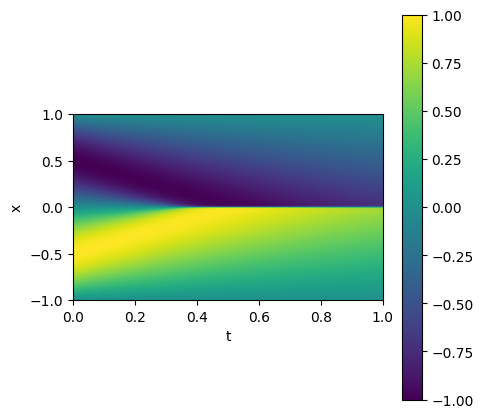

In [4]:
### what is the solution that we want? read in the data

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


Fig. 1: Colormap of velocity (solution values of the Burger's equation)with respect to time and position, and the specified viscosity. This is the result we are trying to achieve by prediction with neural networks. On the +x region, there is a purple hue showing that the velocity is negative, and on the -x region, it shows a yellow-green hue showing that the velocity is ppositive. This indicates that between these two regions, the direction of motion switches. The transition is more gradual in the beginning (at around t= 0 to 0.2) and is sharper and more distinct as t progresses.


# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

#Note:

I'm assuming we're following this equation:


in section 2.1 of https://www.sciencedirect.com/science/article/pii/S2666818121000243#:~:text=The%20one%2Ddimensional%20Burgers'%20equation,u%20(%20x%20%2C%20t%20)%20.

In [5]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [6]:
def fun_u_0(x): #u(0,x) eq 2. #INITIAL CONDITION
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container.  #BOUNDARY
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .   #RESIDUAL Fn.
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

note to self: The residual is the difference between the left-hand side and the right-hand side of the PDE. In this case, the residual seems to be related to a derivative equation

In [7]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [8]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin

#This line creates a tensor t_0 of shape (n_0, 1) where each element is set to tmin. This corresponds to the initial time for your problem.

x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

#x_0 is a tensor specifically containing randomly generated spatial coordinates,
#while X_0 is a tensor combining time and spatial coordinates into a single representation for the initial conditions.
#The variable X_0 is created by concatenating the time tensor t_0 with the spatial coordinate tensor x_0.



<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

^this provides tensor values

# evaluate initial condition at x_0

In [9]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.71221125],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890798 ],
       [ 0.7587    ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.6007799 ],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.93767726],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.9424197 ],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

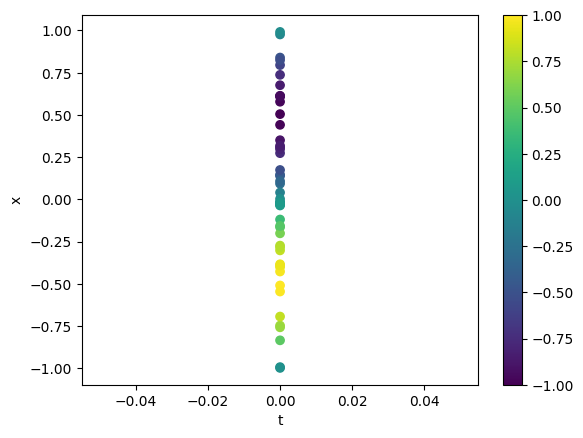

In [10]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");
#ADDED COLORBAR
# pl.colorbar()

#so these plot the initial conditions relating to x and t, given u(0, x)...(?)

Fig. 2: Scatterplot showing the initial conditions, pertaining x and t, to the solutions. These initial conditions would give us the initial conditions for the velocity (u(0, x)), which values are shown by the colors. These generated values all pertain to t = 0, the initial condition.

# get data at boundaries of x at random t's



In [11]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754,  1.        ],
       [ 0.12354946,  1.        ],
       [ 0.7718717 , -1.        ],
       [ 0.6850728 ,  1.        ],
       [ 0.6442598 , -1.        ],
       [ 0.07745004, -1.        ],
       [ 0.75058556,  1.        ],
       [ 0.6250843 , -1.        ],
       [ 0.00772953,  1.        ],
       [ 0.55370283,  1.        ],
       [ 0.83894694, -1.        ],
       [ 0.43658102, -1.        ],
       [ 0.9566101 , -1.        ],
       [ 0.7588576 ,  1.        ],
       [ 0.8964343 , -1.        ],
       [ 0.44467843, -1.        ],
       [ 0.3243779 , -1.        ],
       [ 0.3443855 , -1.        ],
       [ 0.91262174,  1.        ],
       [ 0.77731085,  1.        ],
       [ 0.899588  , -1.        ],
       [ 0.50426483, -1.        ],
       [ 0.45032525,  1.        ],
       [ 0.5939442 , -1.        ],
       [ 0.71862614,  1.        ],
       [ 0.91657436, -1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [12]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

**note to self: why is it all 0. ~ ?? ^^


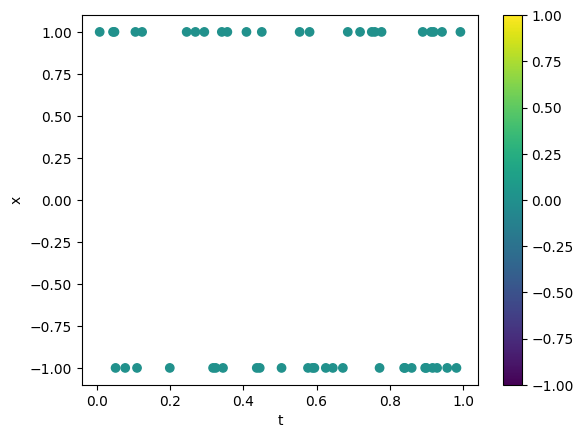

In [13]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");

Fig. 3: Scatterplot of boundary conditions, pertaining x and t, to the solutions (as defined by the function u_b). As set below eq.2, the velocities in these boundary conditions (of x = [-1, 1]) are all 0.

# get points inside the space at random where the function will be predicted

In [14]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

#Important note to self:

The residual in the context of the Burgers' equation (or any partial differential equation) provides a measure of how well the current solution satisfies the differential equation. In other words, it quantifies the extent to which the partial differential equation (PDE) is not satisfied at a particular point in space and time.

The Burgers' equation is given by:

u_t + u*u_x - vu_xx = 0. u_t is  first partial derivative wrt t, and as for x and xx

Residual function is:
res = abs(u_t+u*u_x-v*u_xx).

If the residual is close to zero, it indicates that the current solution satisfies the Burgers' equation at that particular point.
If the residual is large, it implies that the current solution deviates from satisfying the Burgers' equation, and there is room for improvement.

When solving or approximating PDEs numerically, such as using physics-informed neural networks (PINNs) or other methods, the goal is often to minimize the residual over the entire spatial and temporal domain. Minimizing the residual means that the solution becomes a better approximation to the true solution of the PDE.


**Reminder: we had a specified value for the viscosity, and we want to solve for u, the fluid velocity.

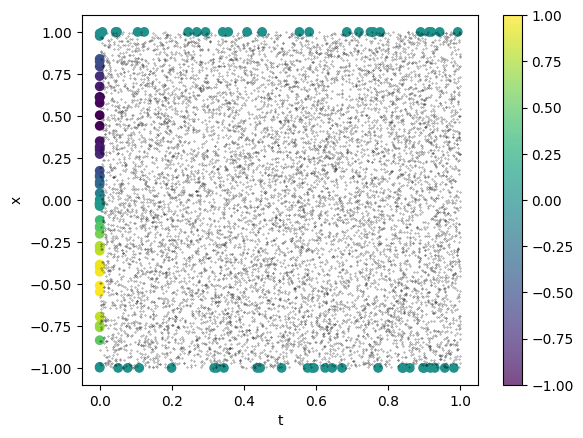

In [15]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");

Fig. 4: Scatterplot of our "generated" values of x and t (namely x_r and t_r for our residual function). These are given by the smaller grey plots throughout the space. The larger, colored, scatterplots mark the initial and boundary conditions in the space (respectively corresponding to u_0 and u_b), which were seperately plotted in Figs. 2 and 3.


(This kinda looks like the particle in a box problem! with initial and boundary conditions!)

In [16]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
#remember: X_0 is a matrix that contains both t_0 and x_0 information
#X_0 = tf.concat([t_0, x_0], axis=1)
#and analogously for X_b
# so X concats both


y = tf.concat([u_0, u_b], axis=0)
#and y pertains the function of u, as a function of x and t. here, y concats both u_0 and u_b


X.shape, y.shape, X_0.shape, u_0.shape, X_b.shape, u_b.shape


(TensorShape([100, 2]),
 TensorShape([100, 1]),
 TensorShape([50, 2]),
 TensorShape([50, 1]),
 TensorShape([50, 2]),
 TensorShape([50, 1]))

# create the model with simple loss

In [17]:
nnmodel = tf.keras.Sequential()
#^initializes an empty Sequential model using the TensorFlow Keras API

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.layers.InputLayer(input_shape=(2,)))


#8 hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation = "tanh"))
  #this was from lecture


  #the number in the Dense fn. is the numebr of neurons (units).
  #Each neuron in the layer is connected to every neuron in the previous layer (or the input layer if this is the first hidden layer)

#output layer is 1D
#as our case here: u --> y
nnmodel.add(tf.keras.layers.Dense(1))


Question to self:
Why do we set input as 2 neurons? Why 8 hidden layers?

Note to self:

https://www.tensorflow.org/api_docs/python/tf/keras

see example: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
^adding input layers

**
However, it's important to note that the InputLayer itself does not specify the number of neurons explicitly. The number of neurons is implicit and is determined by the shape of the input data. In this case, since the input shape is (2,), it is expected that each input sample has two features.

If you want to explicitly specify the number of neurons in the input layer (which is often not necessary in practice), you would use a Dense layer as the first layer instead of InputLayer

**

Sequential Model:

The Sequential model is a linear stack of layers that you can add one at a time.
Layers are added using the add method in the order they are passed.
Initialization:

nnmodel = tf.keras.Sequential() creates an empty Sequential model.
You can subsequently add layers to this model to define the architecture of your neural network.

After initializing the model, you would typically proceed to add layers to it, configure those layers, and then compile the model with an optimizer, loss function, and other settings before training it on your data.


---

In [18]:
# optim = tf.keras.optimizers.Adam(learning_rate=0.001)
# def custom_loss(...):
#   return REPLACEME

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(truth, prediction):
  return tf.reduce_mean(tf.square(truth-prediction))

#also from lecture

^^this is defining optimizer, and loss function.

In [19]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [20]:
history = nnmodel.fit(X, y, epochs=1000)

#are we running epochs 1000 because we want to predict 1000 points within the conditions?

Epoch 1/1000
4/4 [==============================] - 3s 12ms/step - loss: 0.3515
Epoch 2/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1781
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1935
Epoch 4/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1932
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1700
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.1621
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1588
Epoch 8/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1532
Epoch 9/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1486
Epoch 10/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.1516
Epoch 11/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1441
Epoch 12/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1350
Epoch 13/1000
4/4 [==========================

Text(0, 0.5, 'loss')

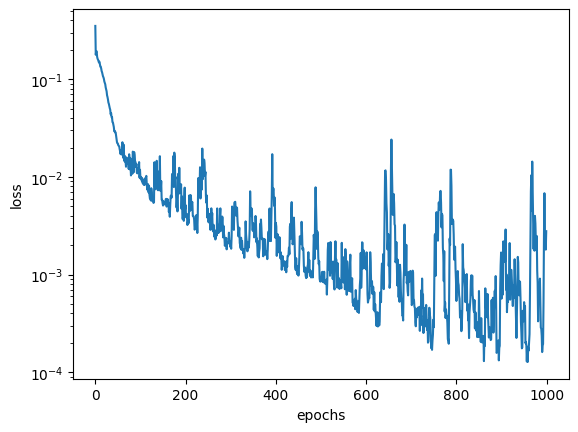

In [21]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

Fig. 5: A plot of the loss fn. vs. the number of epoch for the model we set. We had an input. layer of 2 neurons and 2 dimensions, added 8 hidden layers, and had an output of 1 dimension, with a hyperbolic tangential activation function. The initial and boundary conditions were defined as previously.

The loss function seems to generally go down as the epoch increases, which is slightly a good sign. However, it still seems very messy/noisy. We would want to think of ways to manage or modify this. A possibility for this might be due to parameters such as the learning rate, or even the loss function.

Note to self:
A smaller learning rate typically results in slower but more precise convergence, while a larger learning rate may lead to faster convergence but with the risk of overshooting the optimal solution.

## see the result

In [22]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 2ms/step


array([[ 0.0618969 ],
       [ 0.05162324],
       [ 0.07306097],
       ...,
       [ 0.02588065],
       [ 0.29300144],
       [-0.5405124 ]], dtype=float32)

313/313 [==============================] - 1s 2ms/step


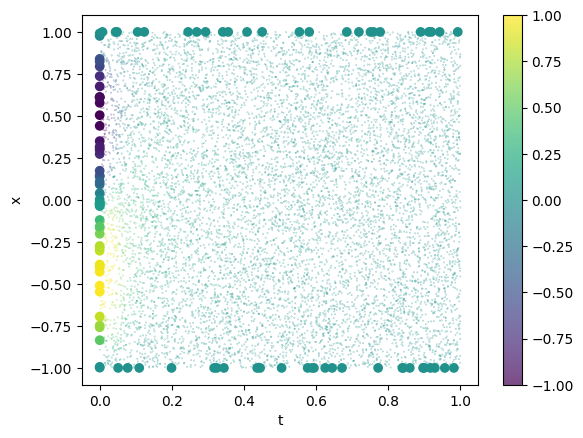

In [23]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");

Fig. 6: Scatterplot of predictions we had for the points in space within the conditions, predicted by the "simple" neural network we set. These are indicated by the smaller dots, showing color corresponding to their predicted u-values. Just by eyeballing this prediction, it seems that most of the predictions show u = 0. Though, one can still somewhat see the purple hue on the +x region and yellow-green hue on the -x region.  This shows the model strives to match what the actual solution in Fig. 1 gives.

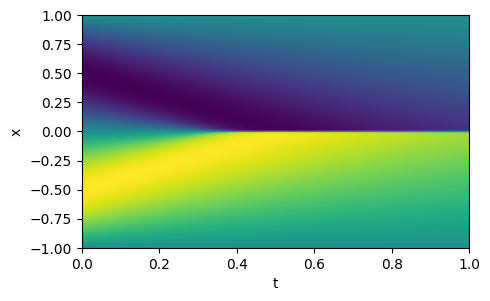

In [24]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
# pl.colorbar()
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


Fig. 7: Figure as in Fig. 1, the analytical solution of the Burger's equation with our given boundary and initial conditions. To compare with our predictions.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


17.140308996783407

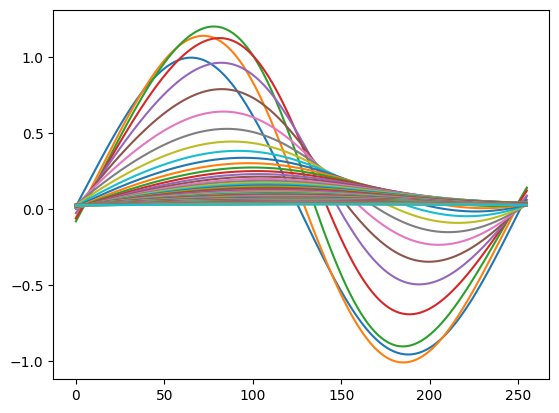

In [25]:
from matplotlib.cm import ScalarMappable
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt] #GIVES FIXED TIME
    pl.plot(model.predict(tmp_))
    #add colormap:
    # color = t[tt]
    # line = pl.plot(model.predict(tmp_), color=pl.cm.viridis(color), label=f't={t[tt]:.2f}')
    ##
    acc += (model.predict(tmp_) - Z[:,tt]).sum()
  # # pl.xlabel = "'Indices'"
  # # pl.ylabel = 'Prediction Values'
  # # sm = ScalarMappable(cmap=pl.cm.viridis)
  # # sm.set_array(t)
  # # cbar = pl.colorbar(sm, label='t-values')
  # pl.xlabel('Indices')  # Set the x-axis label
  # pl.ylabel('Prediction Values')  # Set the y-axis label

    # Add colorbar
  # sm = ScalarMappable(cmap=pl.cm.viridis)
  # sm.set_array(t)
  # cbar = pl.colorbar(sm, label='t-values')

  #   # Add legend
  # pl.legend()

  # pl.show()

  return acc / np.prod(t.shape[0] * x.shape[0]) #Dividing by the total number of elements provides the average L1 error per prediction.


L1accuracy(t, x, nnmodel)

#t.shape[0] gives the size along the first axis.

Fig. 8: Plot of velocity predictions from x and t vs the "indices" of prediction (x-axis), given constant t (tmp_[:,0] = t[tt] in each line). Each color coresponds to different values of t. It can be seen that the lines *generally* follow a sinusoidal trend, which is a lot more apparent for some values of t but not so for some other (they tend to be flatter), hence showing that for some values of constant t, the velocity varies sinusoidally with respect to position, but for some other values they don't vary that way.

The number outputted by the L1 function gives the average L1 error per prediction.

Plot note: I was thinking about how to plot the x and y axes labels, as well as a colormap, but was not sure how. They kept giving me errors.

8/8 [==============================] - 0s 2ms/step


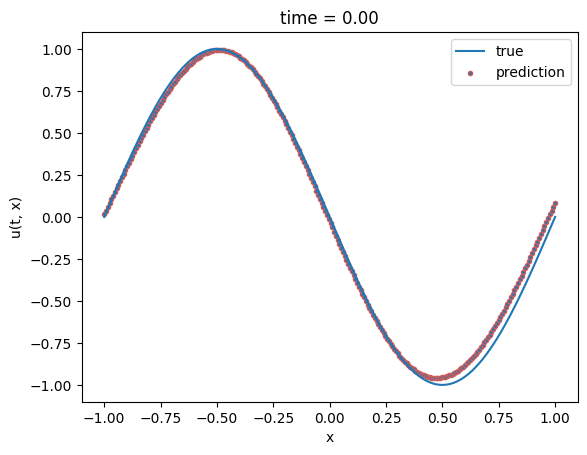

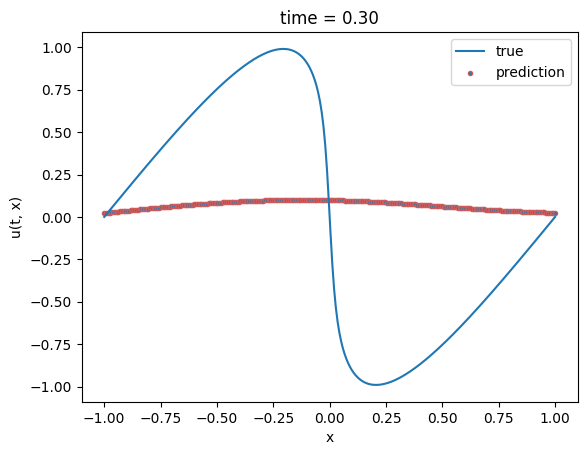

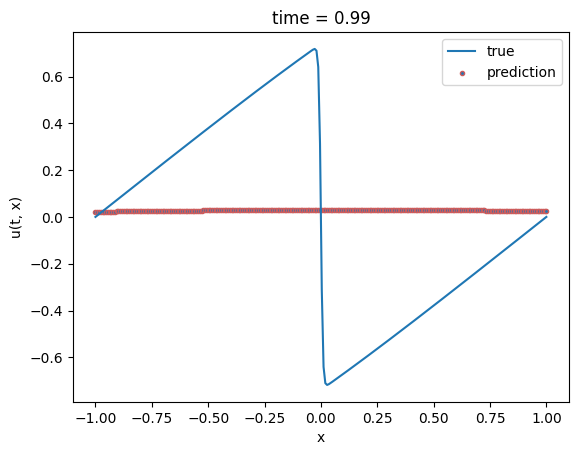

In [26]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


Fig. 9: More explicit visualizations of the constant t u-prediction plots as in Fig.8, but in comparison with the true u-prediction graphs. The top plot shows that for time 0, which shows an almost accurate comparison. Both prediction and true vary sinusoidally. The middle plot shows that for time 0.3, which is less accurate, followed by the bottom plot at time 0.99, which is the least accurate compared to the other 2 (the prediction graph also seems flatter and flatter). This shows how the models get lets accurrate as time increases.

# create the model with complete loss

In [27]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


^computes partial derivatives of a neural network model's output with respect to time and space coordinates

In [28]:
# def custom_loss(model, ...):
#     ...
#     return REPLACEME


def custom_loss(model, X_r, X, y):
    u_pred = model(X)
    loss = tf.reduce_mean(tf.square(y - u_pred))
    u_pred, u_t, u_x, u_xx = get_pde(model, X_r)
    resids = fun_res(u_pred, u_t, u_x, u_xx)
    loss += tf.reduce_mean(tf.square(resids))
    return loss


#this was in lecture

In [29]:
# def get_grad(model, X_r, X, y):
#     # model derivatives for backprop
#     ...

#     return loss, g


def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(model.trainable_variables)
      loss = custom_loss(model, X_r, X, y)

    g = tape.gradient(loss, model.trainable_variables)

    return loss, g

#this was also in the lecture

#this is to calculate the gradient descent.

## train the model

In [30]:
import copy

In [31]:
# pinn = tf.keras.Sequential()

# #input layer with 2 neurons for 2 dimensions
# ...
# #hidden layers
# for i in range(8):
#   ...
# #output layer is 1D
# ...


pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.Input(2))
#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(20, activation='tanh'))
#output layer is 1D
#because it's a regression. so only need 1D
pinn.add(tf.keras.layers.Dense(1))

#also in lecture, the "simple" model

In [32]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

#^.compile ; we changed how we use loss in this function

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)

#THIS CODE^ there is also another "loss". this is put to history
#(compared to history = nnmodel.fit(X, y, epochs=1000) in previous NN code.)

  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))



It 00000: loss = 3.45183551e-01
It 00050: loss = 1.03745103e-01
It 00100: loss = 8.05129707e-02
It 00150: loss = 6.63893446e-02
It 00200: loss = 5.79311624e-02
It 00250: loss = 5.11345938e-02
It 00300: loss = 5.32921106e-02
It 00350: loss = 4.95383739e-02
It 00400: loss = 3.07003483e-02
It 00450: loss = 3.44528481e-02
It 00500: loss = 3.73893902e-02
It 00550: loss = 3.13028023e-02
It 00600: loss = 1.05370907e-02
It 00650: loss = 1.39683578e-02
It 00700: loss = 6.16880693e-03
It 00750: loss = 4.50383872e-03
It 00800: loss = 1.32618677e-02
It 00850: loss = 3.32261948e-03
It 00900: loss = 1.07922971e-01
It 00950: loss = 5.88511787e-02
It 01000: loss = 2.81156655e-02
It 01050: loss = 3.41687948e-02
It 01100: loss = 6.54696394e-03
It 01150: loss = 4.97720856e-03
It 01200: loss = 6.72102254e-03
It 01250: loss = 3.47213773e-03
It 01300: loss = 4.80988109e-03
It 01350: loss = 7.59106362e-03
It 01400: loss = 1.54545263e-03
It 01450: loss = 5.47915176e-02
It 01500: loss = 2.38608290e-03
It 01550

Now here I trained the model with PiNN, instead of NN as in the previous approach above.

313/313 [==============================] - 1s 2ms/step


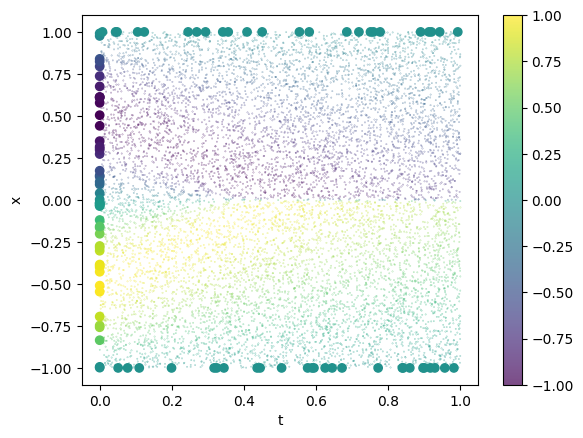

In [33]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");

Fig. 10: Scatterplot of predicted velocity given x and t, as in Fig. 6, but instead of using just an NN, we are using the Physics-Informed NN from our newly defined functions. The Number of Epochs are now 5000 instead of 1000, and we have larger learning rate 0.005. The differences also include that now we are now using our newly defined gradient descent and custom loss (such that they satisfy the Burger conditions) to "fit" to our PiNN model. Compared to Fig. 6, we see a clearer color distinction between the predicted colors, and seemingly more accurate. This plot follows more closely to Fig. 1, where not only is there a "purple" hue on +x and "yellow-green" hue on -x, but also a clearer transition to u = 0 towards the boundary conditions, as well as the blue-hued (around u=0) "triangular region" from around t=(0,0.2) and x = (-0.25, 0.25).




313/313 [==============================] - 1s 2ms/step


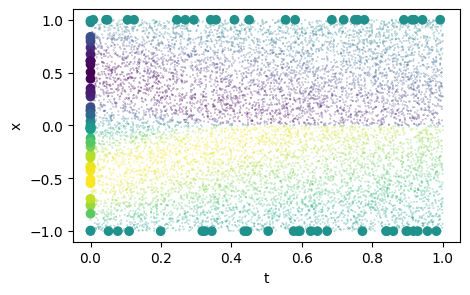

In [34]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
# pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

Fig. 11: Rescaled version of Fig. 10, as an "overplot" of the original dataset plot in Fig. 1. The model does start to do a good job, and gives a more accurate prediction compared to our previous NN model.

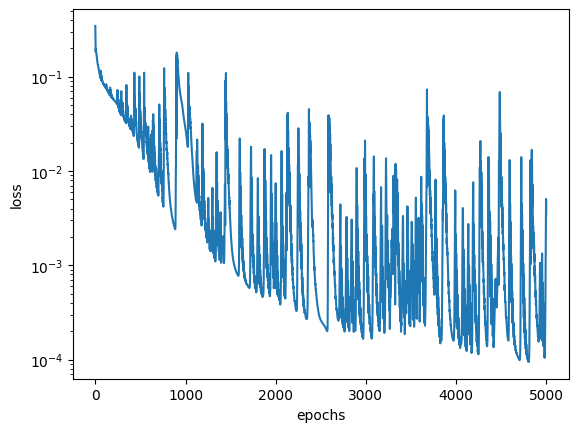

In [35]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

Fig. 12: The loss function vs. epochs for our PiNN. Although our PiNN model gives a better prediction, the loss plot is still very noisy, showing that the model can still do much better in learning the model. Hence, we could change the loss function to make it smaller, and then we can learn again.

8/8 [==============================] - 0s 2ms/step


-1.6810351437331896

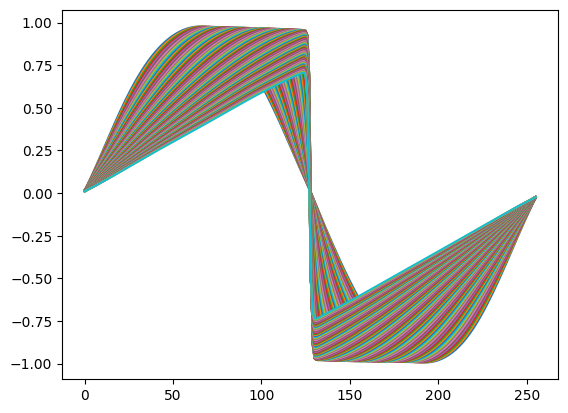

In [36]:
L1accuracy(t, x, pinn)

Fig. 13: Plot of velocity predictions from x and t vs the "indices" of prediction (x-axis), given constant t (tmp_[:,0] = t[tt] in each line), as in Fig. 8 but for our PiNN. Compared to Fig. 8, our graphs do not seem to have a sinusoidal-to-flat trend, but instead, the changes seem to be "steeper"/more drastic w.r.t. position, and this trend pertains through all different values of time.

# adjust the learning rate and trin some more
the loss was awfully noisy

**Hence in this approach, we are decreasing our learning rate, and increasing our number of epochs, for the PiNN-optimized model.

In [37]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [38]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 1.64531276e-03
It 00050: loss = 1.29770036e-04
It 00100: loss = 1.16470299e-04
It 00150: loss = 1.10216126e-04
It 00200: loss = 1.05555489e-04
It 00250: loss = 1.02407415e-04
It 00300: loss = 1.00350255e-04
It 00350: loss = 9.88191387e-05
It 00400: loss = 9.75479052e-05
It 00450: loss = 9.64362916e-05
It 00500: loss = 9.54420102e-05
It 00550: loss = 9.45386855e-05
It 00600: loss = 9.37060977e-05
It 00650: loss = 9.29340531e-05
It 00700: loss = 9.22105100e-05
It 00750: loss = 9.15266719e-05
It 00800: loss = 9.08758811e-05
It 00850: loss = 9.02501633e-05
It 00900: loss = 8.96491983e-05
It 00950: loss = 8.90672236e-05
It 01000: loss = 8.84991241e-05
It 01050: loss = 8.79420841e-05
It 01100: loss = 8.73901445e-05
It 01150: loss = 8.68433490e-05
It 01200: loss = 8.62958041e-05
It 01250: loss = 8.57454361e-05
It 01300: loss = 8.51899094e-05
It 01350: loss = 8.46214825e-05
It 01400: loss = 8.40404682e-05
It 01450: loss = 8.34383609e-05
It 01500: loss = 8.28143893e-05
It 01550

Text(0, 0.5, 'loss')

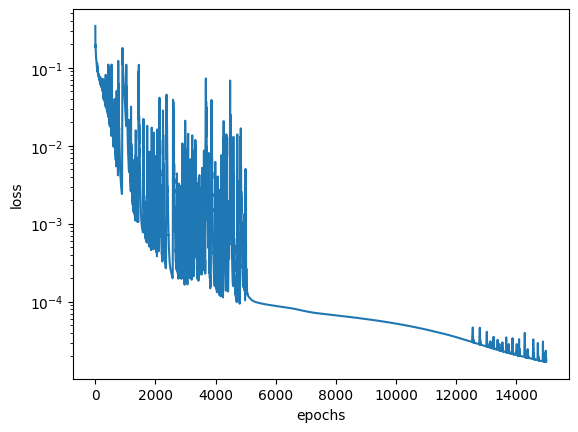

In [39]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

Fig. 14: Loss vs. epochs as for the PiNN, with our changed parameters. In the code before this, we set epochs to be 10000, but in the plot it extends to 15000, as it must have been due to the fact that these 10000 epochs are "appended" to our existing "history" object (by history.append()). The way I see this is that new epochs are added to our existing learning process (hence looking like an extension). This shows a longer and more obvious downward trend to "dissolve" the noisier loss in the beginning epochs. However, we can see it still fluctuates quite a bit, so it is still learning.

In [43]:
print(len(history))

15000


313/313 [==============================] - 1s 2ms/step


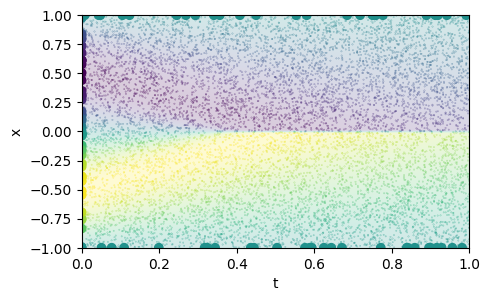

In [41]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

Fig. 15: Scatterplot of the velocity predictions from x and t coordinates, as with Fig. 11 and Fig.6, but using our modified PiNN (appended 10000 epochs with decreased learning rate). Compared to the previous predictions, we see a much clearer resemblance to the original analytic data.

In [42]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 1.67796643e-05
It 00050: loss = 1.66070422e-05
It 00100: loss = 1.64621324e-05
It 00150: loss = 1.63087097e-05
It 00200: loss = 1.61847056e-05
It 00250: loss = 1.61451171e-05
It 00300: loss = 1.93616161e-05
It 00350: loss = 1.58376206e-05
It 00400: loss = 1.56013193e-05
It 00450: loss = 1.54731952e-05
It 00500: loss = 1.58879611e-05
It 00550: loss = 1.53799738e-05
It 00600: loss = 1.50927435e-05
It 00650: loss = 1.49716006e-05
It 00700: loss = 1.51829445e-05
It 00750: loss = 1.47154460e-05
It 00800: loss = 1.49108746e-05
It 00850: loss = 1.44802461e-05
It 00900: loss = 1.46498951e-05
It 00950: loss = 1.42606459e-05
It 01000: loss = 1.41455230e-05
It 01050: loss = 1.43297921e-05
It 01100: loss = 1.80858424e-05
It 01150: loss = 1.38359637e-05
It 01200: loss = 1.96448036e-05
It 01250: loss = 1.36881608e-05
It 01300: loss = 1.36635263e-05
It 01350: loss = 1.35437767e-05
It 01400: loss = 1.42076124e-05
It 01450: loss = 1.32425284e-05
It 01500: loss = 1.31478882e-05
It 01550

Text(0, 0.5, 'loss')

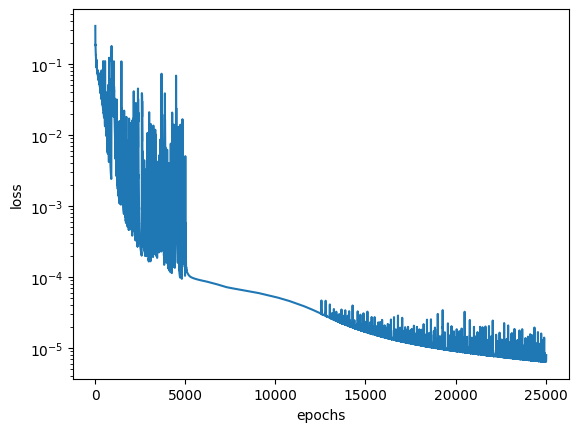

In [43]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

Fig. 16: Another loss vs. epoch plot. Here, we appended more epochs, now having a total of 25000 of them to see how our loss evolves for our PiNN model. There is a general loss decrease trend, but the graph still fluctuates. This shows that the model is still learning

## final result

8/8 [==============================] - 0s 4ms/step


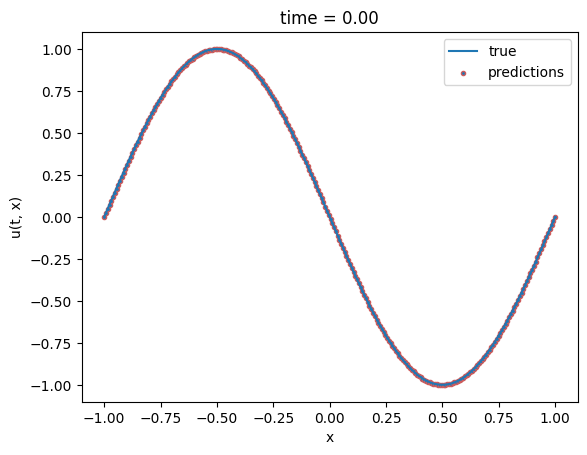

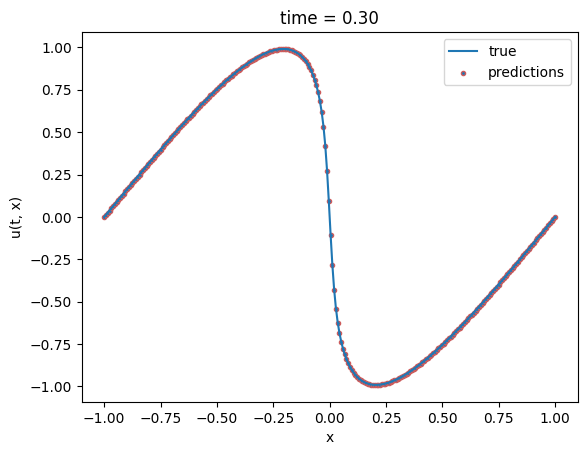

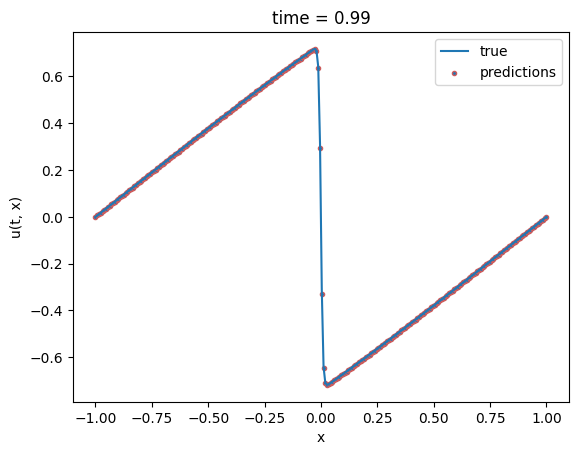

In [47]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed", label = 'predictions')
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();

Fig. 17: Visualizations of the velocity predictions vs. the true velocities at constant t, like in Fig. 9, but for our current updated PiNN. The top plot shows the comparison at t=0, and similar to Fig.9, it is very accurate. Then, followed by the middle plot at t=0.3, where the prediction scatterplot still follows the line graph of the true values. Finally, in the bottom plot, the predictions also follow the true value line, even when the true graph "switches" drastically at around x = 0. This shows that for the shown times, the prediction of u(x) at constant t is (almost) accurate.

313/313 [==============================] - 1s 3ms/step


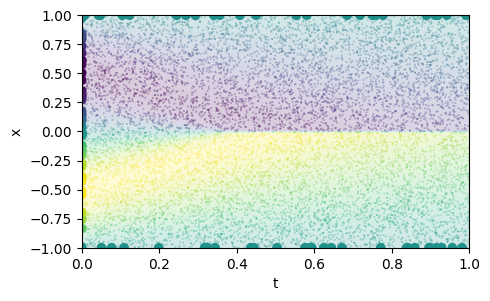

In [45]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

Fig. 18: Scatterplot of the new velocity predictions, plotted over our original dataset. Honestly by eye, this looks quite similar to Fig. 15 as I think that was already quite accurate, but because we are now learning over more epochs, I would say that out prediction in Fig. 18 is more accurate and closer to the analytical solution.

8/8 [==============================] - 0s 3ms/step


-0.15585140584053203

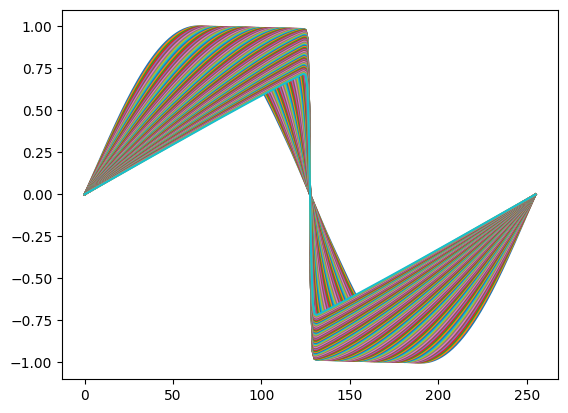

In [46]:
L1accuracy(t, x, pinn)

Fig. 19: Plot of velocity predictions over "indices", each color line showing different constant t values, as in Fig. 8 and 13. We have 25000 epochs in our PiNN. Our graph here looks similar to that in Fig. 13, with 5000 epochs and the corresponding learning rate. This graph also shows how the predictions can change more drastically as x varies, more so as t increases (following Fig. 17).

In [ ]:
#having to wait for NNs to train with CPU is quite insane...
